<h2>COCO mAP</h2>

In [5]:
from collections import defaultdict
import numpy as np
from pathlib import Path
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

IMGS_FOLDER = "/home/modro/datino/Dataset/NAUSICAA/rescue_drone_dataset/images"
GT_COCO_JSON_FILE = "/home/modro/datino/Dataset/NAUSICAA/rescue_drone_dataset/annotations/annotations_person_coco_classes.json"

PRED_COCO_JSON_FILE = "/home/modro/datino/Dataset/NAUSICAA/rescue_drone_dataset/results/vfnet_X_101_64x4d_results.json"

In [3]:
cocoGt = COCO(GT_COCO_JSON_FILE)
cocoDt = cocoGt.loadRes(PRED_COCO_JSON_FILE)

loading annotations into memory...
Done (t=1.45s)
creating index...
index created!
Loading and preparing results...
DONE (t=26.52s)
creating index...
index created!


Let's compute COCO mAP on the entire dataset

In [4]:
# note that, since coco evaluation is classwise, results will be the same also considering all id classes; however, specifying the class id, makes the process faster
class_ids = [1]     # we consider only the person class    

imgIds = sorted(cocoGt.getImgIds())

# running evaluation
cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
cocoEval.params.imgIds  = imgIds
cocoEval.params.catIds = class_ids
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=109.15s).
Accumulating evaluation results...
DONE (t=26.46s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.639
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.206
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=

Let's now compute COCO mAP considering the different heights

In [5]:
imgIds_height = defaultdict(list)

imgIds = sorted(cocoGt.getImgIds())
for img_id in imgIds:
    img_name = cocoGt.loadImgs(img_id)[0]['file_name']
    img_height = img_name.split("_")[3]
    imgIds_height[img_height].append(img_id)
    
cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
for img_height, img_ids in imgIds_height.items():
    print("Evaluating images at {}".format(img_height))
    cocoEval.params.imgIds  = img_ids
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

Evaluating images at 30m
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=126.12s).
Accumulating evaluation results...
DONE (t=32.48s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.148
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.9

<h1>Evaluation using FiftyOne</h1>

In [8]:
from pathlib import Path
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
from sklearn import metrics

import fiftyone as fo
import fiftyone.utils.coco as fouc
from fiftyone import ViewField as F
import fiftyone.brain as fob

ROOT = "/home/modro/datino/Dataset/NAUSICAA/rescue_drone_dataset/"
IMGS_FOLDER = ROOT + 'images'
GT_COCO_JSON_FILE = ROOT + 'annotations/annotations_person_coco_classes.json'

<h3>Prepare data to evaluate</h3>

Importing the dataset and make it persistent (it will be available in the future just loading it, using the <code>load_dataset()</code> function)

In [ ]:
# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=IMGS_FOLDER,
    labels_path=GT_COCO_JSON_FILE,
    name="mob_drone_person",
    label_field="ground_truth",
    tags=['test']
)

# Print summary of the dataset
# print(dataset)

In [15]:
dataset.persistent = True

In [3]:
dataset = fo.load_dataset("mob_drone_person")

Adding detections of specified models to the dataset

In [ ]:
ALL_MODEL_NAMES = ['yolov3', 'centernet_resnet18_dcnv2_140e', 'deformable_detr_twostage_refine_r50_16x2_50e', 'detr_r50_8x2_150e', 'faster_rcnn_x101_64x4d_fpn_mstrain_3x', 'mask_rcnn_x101_64x4d_fpn_mstrai_npoly_3x', 'tood_r101', 'vfnet_X_101_64x4d', 'yolox_x_8x8_300e']
MODEL_NAMES = ['tood_r101', 'vfnet_X_101_64x4d', 'deformable_detr_twostage_refine_r50_16x2_50e']

for model_name in tqdm(MODEL_NAMES):
    PRED_COCO_JSON_FILE = ROOT + 'results/{}_results.json'.format(model_name)
    
    # Add model predictions
    fouc.add_coco_labels(
        dataset,
        "predictions_{}".format(model_name),
        PRED_COCO_JSON_FILE,
    )

    # Saving
    dataset.save()

Adding filtered detections (only persons) of specified models to the dataset

In [4]:
ALL_MODEL_NAMES = ['yolov3', 'centernet_resnet18_dcnv2_140e', 'deformable_detr_twostage_refine_r50_16x2_50e', 'detr_r50_8x2_150e', 'faster_rcnn_x101_64x4d_fpn_mstrain_3x', 'mask_rcnn_x101_64x4d_fpn_mstrai_npoly_3x', 'tood_r101', 'vfnet_X_101_64x4d', 'yolox_x_8x8_300e']
MODEL_NAMES = ['tood_r101', 'vfnet_X_101_64x4d', 'deformable_detr_twostage_refine_r50_16x2_50e']

for model_name in tqdm(MODEL_NAMES):
    PRED_COCO_JSON_FILE = ROOT + 'results/{}_only_person_results.json'.format(model_name)
    
    # Add model predictions
    fouc.add_coco_labels(
        dataset,
        "predictions_{}_only_person".format(model_name),
        PRED_COCO_JSON_FILE,
    )

    # Saving
    dataset.save()

100%|██████████| 3/3 [10:44<00:00, 214.88s/it]


<h3>Add Evaluations</h3>

Evaluating and adding evaluation keys to the dataset

In [9]:
MODELS_TO_EVALUATE = ['deformable_detr_twostage_refine_r50_16x2_50e', 'tood_r101', 'vfnet_X_101_64x4d']

model_results = {}
# model_results_cw_false = {}

# Evaluate using coco evaluator and default settings; specifically, classwise is set to True
for model in tqdm(MODELS_TO_EVALUATE):
    model_results[model] = dataset.evaluate_detections(
        "predictions_{}_only_person".format(model),
        # "predictions_{}".format(model),
        gt_field="ground_truth",
        eval_key="eval_{}".format(model),
        # eval_key="eval_{}_cw_false".format(model),
        compute_mAP=True,
        # classwise = False,
    )
    
    # Saving
    dataset.save()

  0%|          | 0/3 [00:00<?, ?it/s]

Evaluating detections...
 100% |███████████| 126170/126170 [18.9m elapsed, 0s remaining, 75.1 samples/s]       
Performing IoU sweep...
 100% |███████████| 126170/126170 [23.7m elapsed, 0s remaining, 97.0 samples/s]       


 33%|███▎      | 1/3 [43:12<1:26:24, 2592.19s/it]

Evaluating detections...
 100% |███████████| 126170/126170 [21.9m elapsed, 0s remaining, 94.7 samples/s]       
Performing IoU sweep...
 100% |███████████| 126170/126170 [24.0m elapsed, 0s remaining, 82.5 samples/s]       


 67%|██████▋   | 2/3 [1:29:39<45:07, 2707.09s/it]

Evaluating detections...
 100% |███████████| 126170/126170 [15.8m elapsed, 0s remaining, 145.1 samples/s]      
Performing IoU sweep...
 100% |███████████| 126170/126170 [22.2m elapsed, 0s remaining, 106.3 samples/s]      


100%|██████████| 3/3 [2:08:14<00:00, 2564.70s/it]


<h2>Plotting some metrics</h2>

Let's show PR curves for all the models (we consider matches having IoU > 0.5)

In [ ]:
MODELS_TO_EVALUATE = {'yolov3': 'YOLOv3', 'centernet_resnet18_dcnv2_140e': 'CenterNet', 'deformable_detr_twostage_refine_r50_16x2_50e': 'Deformable DETR', 'detr_r50_8x2_150e': 'DETR', 'faster_rcnn_x101_64x4d_fpn_mstrain_3x': 'Faster RCNN', 'mask_rcnn_x101_64x4d_fpn_mstrai_npoly_3x': 'Mask RCNN', 'tood_r101': 'TOOD', 'vfnet_X_101_64x4d': 'VarifocalNet', 'yolox_x_8x8_300e': 'YOLOX'}
model_config_names = [k for k in MODELS_TO_EVALUATE.keys()]

cols, rows = 3, 3
fig, ax = plt.subplots(rows, cols, figsize=(21, 21))

counter = 0
for i in range(rows):
    for j in range(cols):
        precision = model_results[model_config_names[counter]].precision[0][1]     # element 0 concerns IoU=0.5, element 1 concerns class 'person'
        recall = model_results[model_config_names[counter]].recall
        auc = metrics.auc(recall, precision)    # computing auc
        
        ax[i][j].step(recall, precision, color='royalblue', label="AP = {}, class = person".format(round(auc, 2)), linewidth=2.0)
        ax[i][j].fill_between(recall, precision, step='pre', alpha=0.25, color='royalblue')
        
        ax[i][j].set_title('{}'.format(MODELS_TO_EVALUATE[model_config_names[counter]]), fontsize=16)
        ax[i][j].set_ylabel('Precision', fontsize=13)
        ax[i][j].set_xlabel('Recall', fontsize=13)
        ax[i][j].legend(fontsize=15, fancybox=True, loc="upper center")
        
        ax[i][j].set_xlim([0.0, 1.0])
        ax[i][j].set_ylim([0.0, 1.05])
        
        ax[i][j].grid(linestyle='-.', linewidth=0.2)
        ax[i][j].set_ylim([0.0, 1.05])
        
        counter += 1

plt.show()

Let's compare PR curves of the three best models

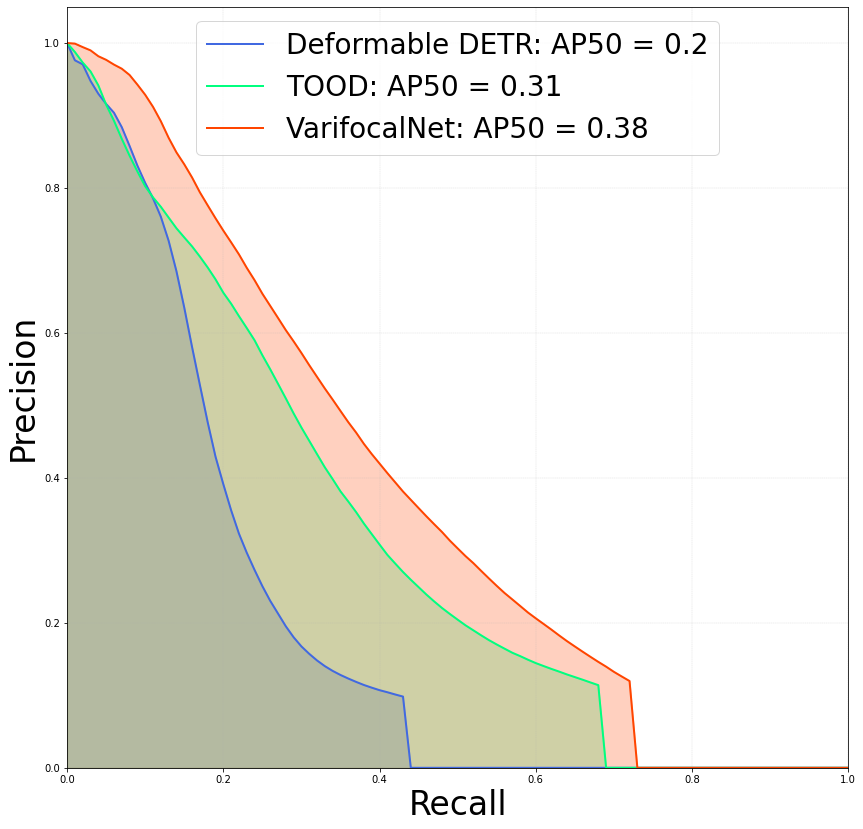

In [14]:
MODELS_TO_EVALUATE = {'deformable_detr_twostage_refine_r50_16x2_50e': 'Deformable DETR', 'tood_r101': 'TOOD', 'vfnet_X_101_64x4d': 'VarifocalNet'}

colours = {'deformable_detr_twostage_refine_r50_16x2_50e': "royalblue", 'tood_r101': "springgreen", "vfnet_X_101_64x4d": "orangered"}

fig, ax = plt.subplots(figsize=(14, 14))

for key, elem in MODELS_TO_EVALUATE.items():
    precision = model_results[key].precision[0][1]     # element 0 concerns IoU=0.5, element 1 concerns class 'person'
    recall = model_results[key].recall
    auc = metrics.auc(recall, precision)    # computing auc
    
    color = colours[key]
    
    # ax.step(recall, precision, color=color, label="{}: AP50 = {}".format(MODELS_TO_EVALUATE[key], round(auc, 2)), linewidth=2.0)
    ax.plot(recall, precision, color=color, label="{}: AP50 = {}".format(MODELS_TO_EVALUATE[key], round(auc, 2)), linewidth=2.0)
    # ax.fill_between(recall, precision, step='pre', alpha=0.25, color=color)
    ax.fill_between(recall, precision, alpha=0.25, color=color)
    
# ax.set_title('Comparison PR curves - 3 best models'.format(MODELS_TO_EVALUATE[key]), fontsize=25)
ax.set_ylabel('Precision', fontsize=33)
ax.set_xlabel('Recall', fontsize=33)
ax.legend(fontsize=28, fancybox=True, loc="upper center")
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.grid(linestyle='-.', linewidth=0.2)
ax.set_ylim([0.0, 1.05])


plt.show()

Let's plot F1-threhsold curve

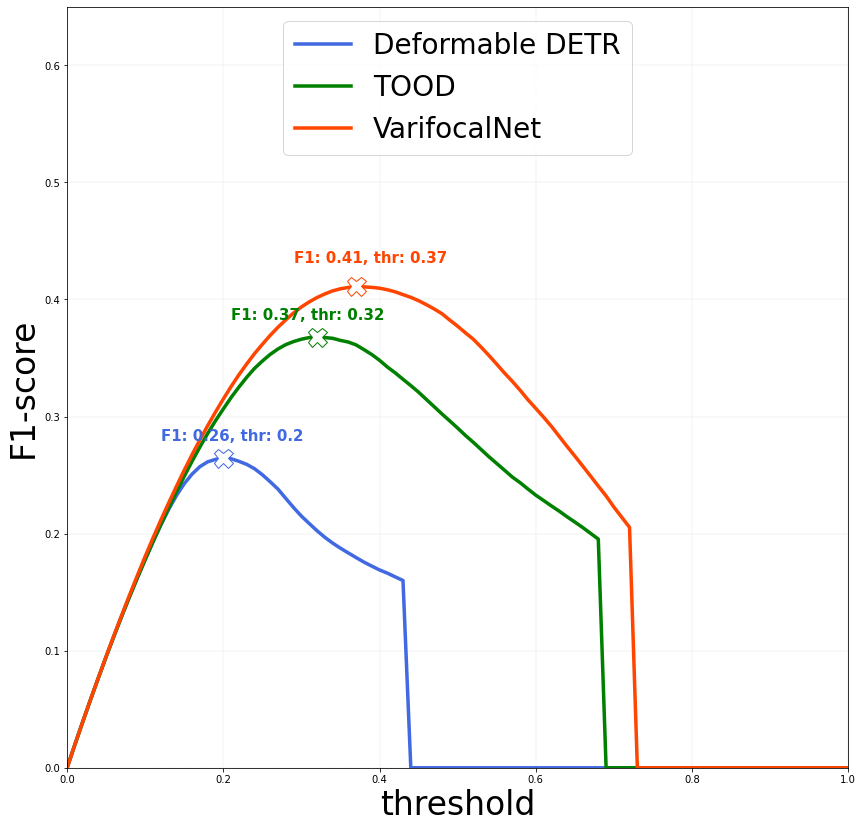

In [31]:
MODELS_TO_EVALUATE = {'deformable_detr_twostage_refine_r50_16x2_50e': 'Deformable DETR', 'tood_r101': 'TOOD', 'vfnet_X_101_64x4d': 'VarifocalNet'}

colours = {'deformable_detr_twostage_refine_r50_16x2_50e': "royalblue", 'tood_r101': "green", "vfnet_X_101_64x4d": "orangered"}

fig, ax = plt.subplots(figsize=(14, 14))

for key, elem in MODELS_TO_EVALUATE.items():
    f1_score = []
    precision = model_results[key].precision[0][1]     # element 0 concerns IoU=0.5, element 1 concerns class 'person'
    recall = model_results[key].recall
    
    color = colours[key]

    for prec, rec in zip(precision, recall):
        f1_score.append(2 * (prec * rec) / (prec + rec))
        
    index_max_f1 = max(range(len(f1_score)), key=f1_score.__getitem__)
        
    ax.plot(recall, f1_score, color=color, label="{}".format(MODELS_TO_EVALUATE[key]), linewidth=3.5)
    ax.plot(recall[index_max_f1], f1_score[index_max_f1], marker="X", color="white", ms=19, mec=color)
    if key == 'tood_r101':
        ax.text(recall[index_max_f1]-0.11, f1_score[index_max_f1]+0.015, s="F1: {}, thr: {}".format(round(f1_score[index_max_f1], 2), recall[index_max_f1]), color=color, fontweight='bold', fontsize=15)
    elif key == 'deformable_detr_twostage_refine_r50_16x2_50e':
        ax.text(recall[index_max_f1]-0.08, f1_score[index_max_f1]+0.015, s="F1: {}, thr: {}".format(round(f1_score[index_max_f1], 2), recall[index_max_f1]), color=color, fontweight='bold', fontsize=15)
    else:
        ax.text(recall[index_max_f1]-0.08, f1_score[index_max_f1]+0.02, s="F1: {}, thr: {}".format(round(f1_score[index_max_f1], 2), recall[index_max_f1]), color=color, fontweight='bold', fontsize=15)

# ax.set_title('Comparison F1-threshol curves - 3 best models'.format(MODELS_TO_EVALUATE[key]), fontsize=25)
ax.set_ylabel('F1-score', fontsize=33)
ax.set_xlabel('threshold', fontsize=33)
ax.legend(fontsize=28, fancybox=True, loc="upper center")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.grid(linestyle='-.', linewidth=0.2)
ax.set_ylim([0.0, 0.65])

plt.show()

Let's plot the confusion matrix

In [ ]:
coco_classes = [
    {'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}, {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}, {'supercategory': 'animal', 'id': 16, 'name': 'bird'}, {'supercategory': 'animal', 'id': 17, 'name': 'cat'}, {'supercategory': 'animal', 'id': 18, 'name': 'dog'}, {'supercategory': 'animal', 'id': 19, 'name': 'horse'}, {'supercategory': 'animal', 'id': 20, 'name': 'sheep'}, {'supercategory': 'animal', 'id': 21, 'name': 'cow'}, {'supercategory': 'animal', 'id': 22, 'name': 'elephant'}, {'supercategory': 'animal', 'id': 23, 'name': 'bear'}, {'supercategory': 'animal', 'id': 24, 'name': 'zebra'}, {'supercategory': 'animal', 'id': 25, 'name': 'giraffe'}, {'supercategory': 'accessory', 'id': 27, 'name': 'backpack'}, {'supercategory': 'accessory', 'id': 28, 'name': 'umbrella'}, {'supercategory': 'accessory', 'id': 31, 'name': 'handbag'}, {'supercategory': 'accessory', 'id': 32, 'name': 'tie'}, {'supercategory': 'accessory', 'id': 33, 'name': 'suitcase'}, {'supercategory': 'sports', 'id': 34, 'name': 'frisbee'}, {'supercategory': 'sports', 'id': 35, 'name': 'skis'}, {'supercategory': 'sports', 'id': 36, 'name': 'snowboard'}, {'supercategory': 'sports', 'id': 37, 'name': 'sports ball'}, {'supercategory': 'sports', 'id': 38, 'name': 'kite'}, {'supercategory': 'sports', 'id': 39, 'name': 'baseball bat'}, {'supercategory': 'sports', 'id': 40, 'name': 'baseball glove'}, {'supercategory': 'sports', 'id': 41, 'name': 'skateboard'}, {'supercategory': 'sports', 'id': 42, 'name': 'surfboard'}, {'supercategory': 'sports', 'id': 43, 'name': 'tennis racket'}, {'supercategory': 'kitchen', 'id': 44, 'name': 'bottle'}, {'supercategory': 'kitchen', 'id': 46, 'name': 'wine glass'}, {'supercategory': 'kitchen', 'id': 47, 'name': 'cup'}, {'supercategory': 'kitchen', 'id': 48, 'name': 'fork'}, {'supercategory': 'kitchen', 'id': 49, 'name': 'knife'}, {'supercategory': 'kitchen', 'id': 50, 'name': 'spoon'}, {'supercategory': 'kitchen', 'id': 51, 'name': 'bowl'}, {'supercategory': 'food', 'id': 52, 'name': 'banana'}, {'supercategory': 'food', 'id': 53, 'name': 'apple'}, {'supercategory': 'food', 'id': 54, 'name': 'sandwich'}, {'supercategory': 'food', 'id': 55, 'name': 'orange'}, {'supercategory': 'food', 'id': 56, 'name': 'broccoli'}, {'supercategory': 'food', 'id': 57, 'name': 'carrot'}, {'supercategory': 'food', 'id': 58, 'name': 'hot dog'}, {'supercategory': 'food', 'id': 59, 'name': 'pizza'}, {'supercategory': 'food', 'id': 60, 'name': 'donut'}, {'supercategory': 'food', 'id': 61, 'name': 'cake'}, {'supercategory': 'furniture', 'id': 62, 'name': 'chair'}, {'supercategory': 'furniture', 'id': 63, 'name': 'couch'}, {'supercategory': 'furniture', 'id': 64, 'name': 'potted plant'}, {'supercategory': 'furniture', 'id': 65, 'name': 'bed'}, {'supercategory': 'furniture', 'id': 67, 'name': 'dining table'}, {'supercategory': 'furniture', 'id': 70, 'name': 'toilet'}, {'supercategory': 'electronic', 'id': 72, 'name': 'tv'}, {'supercategory': 'electronic', 'id': 73, 'name': 'laptop'}, {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'}, {'supercategory': 'electronic', 'id': 75, 'name': 'remote'}, {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'}, {'supercategory': 'electronic', 'id': 77, 'name': 'cell phone'}, {'supercategory': 'appliance', 'id': 78, 'name': 'microwave'}, {'supercategory': 'appliance', 'id': 79, 'name': 'oven'}, {'supercategory': 'appliance', 'id': 80, 'name': 'toaster'}, {'supercategory': 'appliance', 'id': 81, 'name': 'sink'}, {'supercategory': 'appliance', 'id': 82, 'name': 'refrigerator'}, {'supercategory': 'indoor', 'id': 84, 'name': 'book'}, {'supercategory': 'indoor', 'id': 85, 'name': 'clock'}, {'supercategory': 'indoor', 'id': 86, 'name': 'vase'}, {'supercategory': 'indoor', 'id': 87, 'name': 'scissors'}, {'supercategory': 'indoor', 'id': 88, 'name': 'teddy bear'}, {'supercategory': 'indoor', 'id': 89, 'name': 'hair drier'}, {'supercategory': 'indoor', 'id': 90, 'name': 'toothbrush'}
]
coco_class_names = [cl['name'] for cl in coco_classes]

class_names = ['person', 'airplane', 'bird', 'kite']

plot = model_results_cw_false["vfnet_X_101_64x4d"].plot_confusion_matrix(classes=class_names, backend="matplotlib", figsize=(30, 30), include_missing=False)
plot.show()

Let's compute FPs, TPs and FNs for specific model predictions

In [ ]:
#eval_tood_r101_cw_false_fp

fp_view = dataset.filter_labels(
    "predictions_tood_r101", 
    (F("eval_tood_r101")=="fp") # & (F("confidence") > 0.7)
)

sample = fp_view.take(1).first()

print(type(sample))
# fiftyone.core.sample.SampleView

same_sample = fp_view[sample.id]
also_same_sample = fp_view[sample.filepath]

print(same_sample)
print(also_same_sample)

In [ ]:
# Convert to evaluation patches
# eval_patches = dataset.to_evaluation_patches("eval_tood_r101")
#print(eval_patches)

with open(Path("/mnt/datino/NAUSICAA/rescue_drone_dataset/results/tood_r101_only_person_results.json")) as json_ann_file:
    json_ann = json.load(json_ann_file)

num_predictions = len(json_ann)
print(len(json_ann))

print(dataset.count_values("ground_truth.detections.label"))

eval_patches = (
    dataset
    .filter_labels(
        "predictions_tood_r101",
        (F("label") == "person")
    )
).to_evaluation_patches("eval_tood_r101")

print(eval_patches.count_values("type"))

#for eval_patch in eval_patches:
#    print("OK")

<h2>Utility Functions</h2>

Filter detections considering only the ones belonging to person and save in a new json file

In [ ]:
MODELS = ['yolov3', 'centernet_resnet18_dcnv2_140e', 'deformable_detr_twostage_refine_r50_16x2_50e', 'detr_r50_8x2_150e', 'faster_rcnn_x101_64x4d_fpn_mstrain_3x', 'mask_rcnn_x101_64x4d_fpn_mstrai_npoly_3x', 'tood_r101', 'vfnet_X_101_64x4d', 'yolox_x_8x8_300e']

for model in tqdm(MODELS):
    dst_ann = []
    pred_json_file = "/mnt/datino/NAUSICAA/rescue_drone_dataset/results/{}_results.json".format(model)
    dest_pred_json_file = "/mnt/datino/NAUSICAA/rescue_drone_dataset/results/{}__only_person_results.json".format(model)
    
    with open(Path(pred_json_file)) as json_ann_file:
        json_ann = json.load(json_ann_file)
        
    for ann in json_ann:
        if ann['category_id'] == 1:
            dst_ann.append(ann)
            
    with open(dest_pred_json_file, 'w') as fp:
        json.dump(dst_ann, fp)

print("Done")

Filter detections considering only the ones having a score above a specified threshold

In [ ]:
MODELS = ['yolov3', 'centernet_resnet18_dcnv2_140e', 'deformable_detr_twostage_refine_r50_16x2_50e', 'detr_r50_8x2_150e', 'faster_rcnn_x101_64x4d_fpn_mstrain_3x', 'mask_rcnn_x101_64x4d_fpn_mstrai_npoly_3x', 'tood_r101', 'vfnet_X_101_64x4d', 'yolox_x_8x8_300e']

threshold = 0.1

for model in tqdm(MODELS):
    dst_ann = []
    pred_json_file = "/mnt/datino/NAUSICAA/rescue_drone_dataset/results/{}_results.json".format(model)
    dest_pred_json_file = "/mnt/datino/NAUSICAA/rescue_drone_dataset/results/{}_thresh_{}_results.json".format(model, threshold)
    
    with open(Path(pred_json_file)) as json_ann_file:
        json_ann = json.load(json_ann_file)
        
    for ann in json_ann:
        if ann['score'] > threshold:
            dst_ann.append(ann)
            
    with open(dest_pred_json_file, 'w') as fp:
        json.dump(dst_ann, fp)

print("Done")

Filter detections considering only the ones having a specific height

In [ ]:
GT_COCO_JSON_FILE = "/mnt/datino/NAUSICAA/rescue_drone_dataset/annotations/annotations_person_coco_classes.json"

cocoGt = COCO(GT_COCO_JSON_FILE)

MODELS = ['deformable_detr_twostage_refine_r50_16x2_50e', 'tood_r101', 'vfnet_X_101_64x4d']

heights = [10, 20, 30, 40, 50, 60]

for h in heights:
    for model_name in tqdm(MODELS):
        dst_ann = []
        pred_json_file = "/mnt/datino/NAUSICAA/rescue_drone_dataset/results/{}_only_person_results.json".format(model_name)
        dest_pred_json_file = "/mnt/datino/NAUSICAA/rescue_drone_dataset/results/{}_only_person_height_{}_results.json".format(model_name, h)
        
        with open(Path(pred_json_file)) as json_ann_file:
            json_ann = json.load(json_ann_file)
            
        for ann in json_ann:
            image_id = ann["image_id"]
            image_height = int(cocoGt.loadImgs(image_id)[0]['file_name'].split("_")[3].split("m")[0])
            if image_height == h:
                dst_ann.append(ann)
                
        with open(dest_pred_json_file, 'w') as fp:
            json.dump(dst_ann, fp)

print("Done")

Show some sample of detections

In [ ]:
IMGS_FOLDER = "/mnt/datino/NAUSICAA/rescue_drone_dataset/images"
GT_COCO_JSON_FILE = "/mnt/datino/NAUSICAA/rescue_drone_dataset/annotations/annotations_person_coco_classes.json"
PRED_COCO_JSON_FILE = "/mnt/datino/NAUSICAA/rescue_drone_dataset/results/faster_rcnn_x101_64x4d_fpn_mstrain_3x_results.json"

cocoGt = COCO(GT_COCO_JSON_FILE)
cocoDt = cocoGt.loadRes(PRED_COCO_JSON_FILE)

num_sample = 4
bb_width = 4
det_threshold = 0.05

class_colours = {
    'person' : "red",
    'boat': "green",
    'surfboard': "blue",
    'other': "black"
}

imgIds = sorted(cocoGt.getImgIds())
random.shuffle(imgIds)
imgIds = imgIds[:num_sample]

image_to_show = []
for img_id in imgIds:
    # Loading image
    img_name = cocoDt.loadImgs(ids=img_id)[0]['file_name']
    rgb_image = Image.open(Path(IMGS_FOLDER) / img_name)
    draw = ImageDraw.Draw(rgb_image)
    
    # Loading associated annotations
    annIds = cocoDt.getAnnIds(imgIds=img_id)
    anns = cocoDt.loadAnns(ids=annIds)
    for ann in anns:
        category_name = cocoDt.loadCats(ann['category_id'])[0]['name']
        if category_name not in class_colours.keys(): 
            category_name = 'other'
        score = ann['score']
        if score > det_threshold:
            bbox = ann['bbox']
            draw.rectangle(((bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3])), width=bb_width, outline=class_colours[category_name])
        
    image_to_show.append(np.asarray(rgb_image))
    
fig, axes = plt.subplots(1, num_sample, figsize=(100, 100))
axes = axes.flatten()
for i in range(num_sample):
    axes[i].imshow(image_to_show[i])

for ax in axes:
    ax.set_axis_off()
            
plt.show()

for i in range(num_sample):
    plt.imsave("trash/sample_det__{}.png".format(i), image_to_show[i])